# Introduction to deep learning

Hello friends!

Been wanting to give deep learning a go on this GTC but aren't sure where to start?

Let's start together!

We'll be using [PyTorch](https://pytorch.org/) for the nuts and bolts of our deep learning setup, [PyTorch Lightning](https://www.pytorchlightning.ai/) to build and manage a model pipeline, [WandB](https://wandb.ai/) to log metrics and track experiments, and a few other libraries here and there including our beloved basics.

## Setting up a dataloader

The first thing we'll need to efficiently train a DNN is a [dataloader](). This is a PyTorch class tasked with going onto disk and fetching the data we're using to train our model. The nifty thing about dataloaders is that they're incredibly optimised, seamlessly running in parallel and pulling data into active memory before it's needed so that our programme is (at least in an ideal world) bound only by CPU/GPU constraints and the computationally-intensive processes of forward and backward propagation, not by the boring processes of disk i/o.

To keep things simple and small, let's use the four image pairs in `sar/` and `chart/` for this tutorial. In our real implementation, we'll replace these folders with the source folders for all data.


In [320]:
import os
import matplotlib.pyplot as plt
from skimage import io
from torch.utils.data import Dataset
from torchvision import transforms


class SeaIceDataset(Dataset):
    """
    An implementation of a PyTorch dataset for loading sea ice SAR/chart image pairs.
    Inspired by https://pytorch.org/tutorials/beginner/data_loading_tutorial.html.
    """

    def __init__(self, sar_path: str, chart_path: str, transform: transforms = None):
        """
        Constructs a SeaIceDataset.
        :param sar_path: Path to the source folder of SAR images
        :param chart_path: Path to the source folder of corresponding chart labels
        :param transform: Callable transformation to apply to images upon loading
        """
        self.sar_path = sar_path
        self.sar_files = os.listdir(self.sar_path)
        self.chart_path = chart_path
        self.chart_files = os.listdir(self.chart_path)
        self.transform = transform

    def __len__(self):
        """
        Implements the len(SeaIceDataset) magic method. Required to implement by Dataset superclass.
        When training/testing, this method tells our training loop how much longer we have to go in our Dataset.
        :return: Length of SeaIceDataset
        """
        return len(self.sar_files)

    def __getitem__(self, i: int):
        """
        Implements the SeaIceDataset[i] magic method. Required to implement by Dataset superclass.
        When training/testing, this method is used to actually fetch data.
        :param i: Index of which image pair to fetch
        :return: Dictionary with SAR and chart pair
        """
        sar_name = os.path.join(self.sar_path, self.sar_files[i])
        chart_name = os.path.join(self.chart_path, self.chart_files[i])
        sar = io.imread(sar_name).copy()  # take all bands for shape of 256 x 256 x 3
        chart = io.imread(chart_name).copy()[:, :, 0]  # take red band only for shape of 256 x 256 x 1
        chart[chart < 80] = 0  # binarise to water
        chart[chart >= 80] = 255  # binarise to ice
        sample = {"sar": sar, "chart": chart}
        if self.transform:
            sample = {"sar": self.transform(sar), "chart": self.transform(chart).squeeze(0).long()}
        return sample

    def visualise(self, i):
        """
        Allows us to visualise a particular SAR/chart pair.
        :param i: Index of which image pair to visualise
        :return: None
        """
        sample = self[i]
        fig, ax = plt.subplots(1, 2)
        ax[0].imshow(sample["sar"])
        ax[1].imshow(sample["chart"])
        plt.tight_layout()
        plt.show()

Now that we've got our `SeaIceDataset` class implemented, let's give it a quick test run and see all that it's capable of.

In [321]:
dataset = SeaIceDataset(sar_path="./sar", chart_path="./chart", transform=None)
dataset[0]  # we can access an item with __getitem__

{'sar': array([[[150, 151, 155],
         [151, 152, 156],
         [150, 151, 155],
         ...,
         [188, 193, 189],
         [188, 192, 191],
         [190, 194, 193]],
 
        [[148, 149, 153],
         [149, 150, 154],
         [149, 150, 154],
         ...,
         [189, 194, 190],
         [189, 193, 192],
         [190, 194, 193]],
 
        [[146, 147, 151],
         [147, 148, 152],
         [147, 148, 152],
         ...,
         [190, 194, 193],
         [189, 193, 192],
         [190, 194, 195]],
 
        ...,
 
        [[ 11,  10,   6],
         [ 11,  10,   6],
         [ 11,  10,   6],
         ...,
         [209, 214, 218],
         [206, 211, 215],
         [201, 206, 210]],
 
        [[ 11,  10,   6],
         [ 11,  10,   6],
         [ 11,  10,   6],
         ...,
         [209, 214, 218],
         [207, 212, 216],
         [203, 208, 212]],
 
        [[ 11,  10,   6],
         [ 11,  10,   6],
         [ 11,  10,   6],
         ...,
         [205, 210, 2

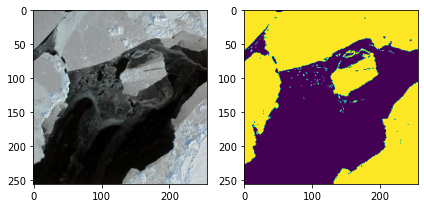

In [322]:
dataset.visualise(0)  # we can visualise an item with our custom function

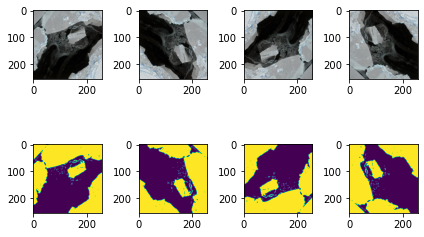

In [323]:
fig, ax = plt.subplots(2, 4)
for i, sample in enumerate(dataset):  # we can iterate through our dataset
    ax[0, i].imshow(sample["sar"])
    ax[1, i].imshow(sample["chart"])
plt.tight_layout()
plt.show()

## Setting up a PyTorch Lightning class

Our next order of business is to build a model skeleton using PyTorch Lightning. PyTorch is great at what it was designed for---building computational graphs of neural networks, computing gradients through autodifferentiation, and efficiently parallelising tensor operations across CPUs/GPUs---but it was not designed for scaling up entire ecosystems of model pipelines with associated datastreams and pre/post-processing steps. PyTorch Lightning takes care of all this leftover stuff. It's a library designed to operationalise and scale DL models and to lighten the cognitive burden of DL devops.

In the words of the PyTorch Lightning team on their [website](https://www.pytorchlightning.ai/),
> What is PyTorch Lightning? Lightning makes coding complex networks simple. Spend more time on research, less on engineering. It is fully flexible to fit any use case and built on pure PyTorch so there is no need to learn a new language. A quick refactor will allow you to: Run your code on any hardware, Performance & bottleneck profiler, Model checkpointing, 16-bit precision, Run distributed training, Logging, Metrics, Visualization, Early stopping, ... and many more!

If you're new to PyTorch Lightning, I highly recommend checking out [Lightning in 15 Minutes](https://pytorch-lightning.readthedocs.io/en/latest/starter/introduction.html)!

PyTorch Lightning is built around a core class called a `LightningModule` which defines what a training step looks like, what a testing step looks like, how optimisers should be configured, and more.

Let's give it a go and build one to see what all the fuss is about.

In [324]:
import torch
import torch.nn as nn
import pytorch_lightning as pl
from torch.utils.data import DataLoader

class Segmentation(pl.LightningModule):
    """
    A LightningModule designed to perform image segmentation.
    """

    def __init__(self,
                 train_dataloader: DataLoader,
                 val_dataloader: DataLoader,
                 model: nn.Module,
                 criterion: callable,
                 learning_rate: float,
                 metric: callable,
                 ):
        """
        Construct a Segmentation LightningModule.
        Note that we keep hyperparameters separate from dataloaders to prevent data leakage at test time.
        :param train_dataloader: Dataloader with training data, left as None at test time
        :param val_dataloader: Dataloader with validation data, left as None at test time
        :param model: PyTorch model
        :param criterion: PyTorch loss function against which to train model
        :param learning_rate: Float learning rate for our optimiser
        :param metric: PyTorch function for model evaluation
        """
        super().__init__()
        self.train_dataloader = train_dataloader
        self.val_dataloader = val_dataloader
        self.model = model
        self.criterion = criterion
        self.learning_rate = learning_rate
        self.metric = metric

    def training_step(self, batch: dict, batch_idx: int):
        """
        Perform a pass through a batch of training data.
        :param batch: Batch of image pairs
        :param batch_idx: Index of batch
        :return: Loss from this batch of data for use in backprop
        """
        x, y  = batch["sar"], batch["chart"]
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        self.log("train_loss", loss)
        return loss

    def validation_step(self, batch, batch_idx):
        x, y  = batch["sar"], batch["chart"]
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        metric = self.metric(y_hat, y)
        self.log("val_loss", loss)
        self.log("val_metric", metric)
        return loss

    def testing_step(self, batch, batch_idx):
        x, y  = batch["sar"], batch["chart"]
        y_hat = self.model(x)
        loss = self.criterion(y_hat, y)
        metric = self.metric(y_hat, y)
        self.log("test_loss", loss)
        self.log("test_metric", metric)

    def configure_optimizers(self):
        optimizer = torch.optim.Adam(self.parameters(), lr=self.learning_rate)
        return {
            "optimizer": optimizer
        }

## Building a PyTorch model

Alright! We've got a framework to train a model. But we don't have a model!

Let's build a basic UNet from scratch so that we understand everything that's going on behind the scenes.

In the future, we'll likely import a prebuilt and/or pretrained model.

In [325]:
class UNet(nn.Module):
    """
    CNN with skip connections (U-Net) for image segmentation (pixel-wise classification).
    """
    def __init__(self, kernel: int, n_channels: int, n_filters: int, n_classes: int):
        """
        Construct a UNet.
        See following graphical diagram.
        x --a------------------a--> x_5
           x_1 --b-------b--> x_4
                x_2 --> x_3
        :param kernel: Convolutional filter size
        :param n_channels: Number of channels in input image
        :param n_filters: Number of convolutional filters to apply in each convolutional layer
        :param n_classes: Number of possible classes for output pixels
        """
        super().__init__()
        stride = 2  # how far to slide the convolutional filter on each step
        padding = kernel // 2  # how much to pad the image on edges of input
        output_padding = 1  # how much to pad the image on edges of output
        blocks = {}  # a dictionary to store the layers of our network as we build it

        # sequentially construct blocks
        # name is the name of our layer in the blocks dictionary
        # c_in is the number of input channels for each convolutional layer
        # c_out is the number of output channels for each convolutional layer
        # down is a boolean telling us if we're on the downsampling (conv) part of our network or upsampling (convT) part of our network
        for name, c_in, c_out, down in [("in_a", n_channels, n_filters, True),
                                        ("in_b", n_filters, 2 * n_filters, True),
                                        ("out_b", 2 * n_filters, n_filters, False),
                                        ("out_a", 2 * n_filters, n_classes, False)]:
            block = []
            if down:  # construct a convolutional layer that downsamples (stride 2) our image
                block.append(nn.Conv2d(in_channels=c_in,
                                       out_channels=c_out,
                                       kernel_size=kernel,
                                       padding=padding,
                                       stride=stride))
            else:  # construct a transposed convolutional layer that upsamples (stride 2) our image
                block.append(nn.ConvTranspose2d(in_channels=c_in,
                                                out_channels=c_out,
                                                kernel_size=kernel,
                                                padding=padding,
                                                stride=stride,
                                                output_padding=output_padding))
            block.append(nn.BatchNorm2d(num_features=c_out))  # append a batch normalisation module to this block
            block.append(nn.ReLU())  # append a relu activation to this block
            blocks[name] = nn.Sequential(*block)  # make this block a proper sequential unit
        blocks["out"] = nn.Conv2d(in_channels=n_channels + n_classes, # add final conv2d to synthesise output
                                  out_channels=n_classes,
                                  kernel_size=kernel,
                                  padding=padding)
        self.model = nn.ModuleDict(blocks)  # construct sequential model from layers

    def forward(self, x):
        """
        Implement forward step through network.
        See following graphical diagram.
        x --+------------------+--> x_5
           x_1 --+-------+--> x_4
                x_2 --> x_3

        :param x: [Tensor] Input of shape [batch_size, num_in_channels, h, w] from CIFAR10.
        :return: [Tensor] Output of shape [batch_size, num_colours, h, w] with colorization classifications.
        """
        x_1 = self.model["in_a"].forward(x)
        x_2 = self.model["in_b"].forward(x_1)
        x_3 = self.model["out_b"].forward(x_2)
        x_4 = self.model["out_a"].forward(torch.cat((x_3, x_1), dim=1))     # skip connection along channel dimension
        x_5 = self.model["out"].forward(torch.cat((x_4, x), dim=1))         # skip connection along channel dimension
        return x_5

## Testing our PyTorch module

Before we try to train our UNet, let's make sure we can pass data through without issue!

We'll create a UNet that accepts 3 channels as input: HH, HV, and Incidence Angle. We'll let it create 16 convolutional filters in the intermediate layers, and we'll ask it to output 2 channels, one corresponding to the probability of water and the other corresponding to the probability of ice.

We'll set our random seed so that subsequent random initialisations of our network are consistent and reproducible.

In [326]:
torch.manual_seed(0)
n_filters = 16
model = UNet(kernel=3, n_channels=3, n_filters=n_filters, n_classes=2)
print(model)  # shows us a convenient summary of our model

UNet(
  (model): ModuleDict(
    (in_a): Sequential(
      (0): Conv2d(3, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (in_b): Sequential(
      (0): Conv2d(16, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (out_b): Sequential(
      (0): ConvTranspose2d(32, 16, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (out_a): Sequential(
      (0): ConvTranspose2d(32, 2, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), output_padding=(1, 1))
      (1): BatchNorm2d(2, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU()
    )
    (out): Conv2d(5, 2, kernel_size=(3, 3), 

In [222]:
model(dataset[0]["sar"])

TypeError: conv2d() received an invalid combination of arguments - got (numpy.ndarray, Parameter, Parameter, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!numpy.ndarray!, !Parameter!, !Parameter!, !tuple!, !tuple!, !tuple!, int)


Uh oh! What's happened? Our dataloader returns images as numpy arrays but our network expects them to be PyTorch tensors. Let's get that sorted!

In [223]:
t = transforms.ToTensor()
tensor_sar = t(dataset[0]["sar"])
tensor_sar

tensor([[[0.5882, 0.5922, 0.5882,  ..., 0.7373, 0.7373, 0.7451],
         [0.5804, 0.5843, 0.5843,  ..., 0.7412, 0.7412, 0.7451],
         [0.5725, 0.5765, 0.5765,  ..., 0.7451, 0.7412, 0.7451],
         ...,
         [0.0431, 0.0431, 0.0431,  ..., 0.8196, 0.8078, 0.7882],
         [0.0431, 0.0431, 0.0431,  ..., 0.8196, 0.8118, 0.7961],
         [0.0431, 0.0431, 0.0431,  ..., 0.8039, 0.7843, 0.7686]],

        [[0.5922, 0.5961, 0.5922,  ..., 0.7569, 0.7529, 0.7608],
         [0.5843, 0.5882, 0.5882,  ..., 0.7608, 0.7569, 0.7608],
         [0.5765, 0.5804, 0.5804,  ..., 0.7608, 0.7569, 0.7608],
         ...,
         [0.0392, 0.0392, 0.0392,  ..., 0.8392, 0.8275, 0.8078],
         [0.0392, 0.0392, 0.0392,  ..., 0.8392, 0.8314, 0.8157],
         [0.0392, 0.0392, 0.0392,  ..., 0.8235, 0.8039, 0.7882]],

        [[0.6078, 0.6118, 0.6078,  ..., 0.7412, 0.7490, 0.7569],
         [0.6000, 0.6039, 0.6039,  ..., 0.7451, 0.7529, 0.7569],
         [0.5922, 0.5961, 0.5961,  ..., 0.7569, 0.7529, 0.

In [224]:
model(tensor_sar)

ValueError: expected 4D input (got 3D input)

Now what? Images are represented in PyTorch as 3D tensors, with dimensions `C x H x W`, where `C` is the number of channels, `H` is the image height, and `W` is the image width. So we'd expect our network to expect a 3D input, right? Where did it get 4D from? From the concept of batching!

To make a long story short, it's more efficient to pass batches of images through the network and compute gradients over the batches when training a network than to repeatedly pass individual images through the network. Thus, our network expects us to pass a batch of images in as a tensor of shape `N x C x H x W`, where `N` is the number of images in the batch, `C` is the number of channels in each image, `H` is the height of each image, and `W` is the width of each image.

Thus, if we have a batch of images in a variable named `batch` and wanted to access the 4th image, we'd write `batch[3]`. If we wanted to access the 1st channel of the 4th image, we'd write `batch[3, 0]`. If we wanted to access the 10th row of pixels from here, we'd write `batch[3, 0, 9]`. And if we wanted to access the value in the 20th pixel of the 10th row of the 1st channel of the 4th image, we'd write `batch[3, 0, 9, 19]`. We'll probably never need to do that. But hey. Now you know how.

Let's get back on track. We need to turn our 3D tensor into a 4D tensor to pass it into our network. How can we do that? We'll use the `torch.unsqueeze` function, which you can read more about [here](https://pytorch.org/docs/stable/generated/torch.unsqueeze.html). It's similar to `np.newaxis` if you've used that before! We can check our work using the `.shape` function as we go.

In [225]:
tensor_sar.shape

torch.Size([3, 256, 256])

In [226]:
tensor_sar_batch = tensor_sar.unsqueeze(0)
tensor_sar_batch.shape

torch.Size([1, 3, 256, 256])

Sweet. Now we've got a tensor in batch form to work with. Let's give it a go through our network!

In [227]:
output = model(tensor_sar_batch)
output

tensor([[[[-7.4579e-02, -2.8592e-01, -1.2089e-01,  ...,  1.4568e-01,
            1.5439e-01,  5.3822e-01],
          [ 1.2162e-02,  2.4027e-01, -3.1655e-01,  ...,  1.0330e-01,
           -9.5603e-01,  4.0119e-01],
          [-4.1273e-01, -2.0334e-01, -2.8681e-01,  ...,  3.3370e-01,
            9.4018e-02,  7.4471e-01],
          ...,
          [-1.3015e-01,  1.8026e-02, -7.9899e-02,  ...,  1.9404e-01,
            1.0597e-01,  4.1639e-01],
          [-6.4484e-01, -3.8151e-01, -4.6349e-01,  ...,  2.7279e-01,
            2.2938e-01,  6.3164e-01],
          [-8.5164e-02, -1.4501e-01, -1.0853e-01,  ..., -8.9894e-02,
            2.9579e-03,  2.8512e-01]],

         [[-2.2987e-01, -4.1561e-01, -5.6164e-01,  ..., -3.5537e-01,
           -4.3449e-01, -4.0903e-01],
          [-3.1616e-01,  9.3209e-02, -4.7945e-01,  ..., -4.8279e-04,
           -3.9486e-01, -7.9038e-01],
          [-2.5244e-02, -1.1089e-01, -1.9162e-01,  ..., -5.8215e-01,
            5.5555e-02, -1.1675e+00],
          ...,
     

In [228]:
output.shape

torch.Size([1, 2, 256, 256])

Cool beans! Our network takes in batches of shape `N x 3 x 256 x 256` and outputs batches of shape `N x 2 x 256 x 256`, where `N` is batch size and the 2 channels in the output correspond to relative likelihoods of water and ice. Our network isn't trained, so we shouldn't expect it to do anything meaningful.

But let's pretend it does. Then we can simply say that the output channel with higher relative likelihood is the class that our network should predict. For instance, let's look at the channel values in pixel [26, 36] in this output for no particular reason.

In [229]:
output[0, :, 36, 26]

tensor([-0.8961, -0.2784], grad_fn=<SelectBackward0>)

I used a clever little Pythonic trick there to retrieve the channel values: to look at all channels at pixel [36, 26] in the 1st image of the batch, we can use the colon : operator when slicing.

Anyway, we see that channel 1 is larger than channel 0 in this pixel. So, we'd interpret this to mean that the pixel is more likely ice than water, and we'd predict the class of this pixel to be ice. We can operationalise this logic using `argmax` as follows!

In [230]:
output[0, :, 36, 26].argmax()

tensor(1)

As we expect, PyTorch tells us channel 1 has the larger value. If we do this across all pixels, we have a segmentation map!

In [231]:
map = output[0].argmax(0)
map

tensor([[0, 0, 0,  ..., 0, 0, 0],
        [0, 0, 0,  ..., 0, 1, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        ...,
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 1, 1,  ..., 0, 0, 0],
        [1, 0, 1,  ..., 0, 0, 0]])

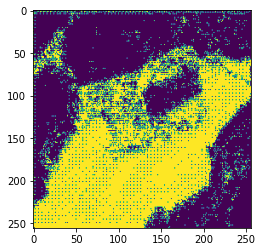

In [232]:
plt.imshow(map.numpy()) # convert torch tensor to numpy array before passing into matplotlib
plt.show()

Hmmmm that looks surprisingly structured without any training! Let's compare it to our input image!

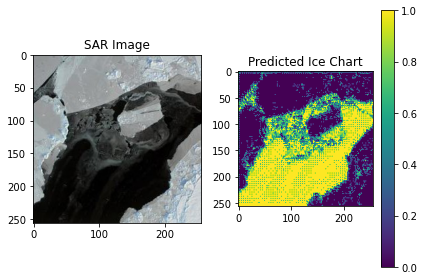

In [304]:
fig, ax = plt.subplots(1, 2)
ax[0].imshow(dataset[0]["sar"])
ax[0].set_title("SAR Image")
scale = ax[1].imshow(map.numpy())
ax[1].set_title("Predicted Ice Chart")
plt.colorbar(scale)
plt.tight_layout()
plt.show()

Well, darn. We said that class 0 (output channel 0 is higher-valued) would be water and class 1 (output channel 1 is higher-valued) would be ice, and our network has it backwards! I suppose we'll have to train it after all. Let's get started.

For the sake of this tutorial, we'll use the same dataset for training, validation, and testing---a big no-no in practice---but you've got to know the rules to know when to break them. Here our goal will be to overfit our model on the training set just to prove that we're able to train it effectively.

Note that we are now using the `transforms.ToTensor()` function in our dataset constructor to transform our uint8 pixels to floating point values. We don't need to do this if we're just visualising the dataset (like we were before), but we do need to do this when training our network as we can't take gradients on integers.

To put our datasets to work, we'll need to pass them into dataloaders, which do exactly what their name suggests... they load... data.

Generally, we'll shuffle training data as it comes in to mix up what the model sees as it learns, but we'll keep validation data unshuffled so that it's easier to evaluate model progress in a consistent manner.

In [327]:
train_dataset = SeaIceDataset(sar_path="./sar", chart_path="./chart", transform=transforms.ToTensor())
train_dataloader = DataLoader(train_dataset, shuffle=True)
val_dataset = SeaIceDataset(sar_path="./sar", chart_path="./chart", transform=transforms.ToTensor())
val_dataloader = DataLoader(val_dataset, shuffle=False)

Before we can construct our `Segmentation` LightningModule class, we need to define a loss function and evaluation metric for our model to use! A typical loss function for segmentation is `CrossEntropyLoss`, and that's what we'll use here. A typical metric is IoU (intersection-over-union) index, also known as the [Jaccard Index](https://en.wikipedia.org/wiki/Jaccard_index), which measures the ratio of overlap between the predicted and true footprint to the union between the predicted and true footprint of a class, and that's what we'll use here.

In [328]:
from torchmetrics import IoU  # may be called Jaccard Index in newer versions of torchmetrics
criterion = nn.CrossEntropyLoss()
learning_rate = 1e-4
metric = IoU(num_classes=2)
segmenter = Segmentation(train_dataloader, val_dataloader, model, criterion, learning_rate, metric)

Alright! Now that we've got our `Segmentation` LightningModule set up, it's time to configure our logging situation with Weights and Biases, also known as [wandb.ai](https://wandb.ai/). We'll tell it to "watch" our model so that it tracks parameter updates and gradients, which can be useful to interrogate when debugging. We'll tell it key experimental configuration settings we've chosen so that we can look back later and remember what we've tried and how well it worked. We'll use a similar approach when doing hyperparameter sweeps.

In [329]:
import wandb
wandb.init(project="sea-ice-classification")  # initialise wandb
wandb_logger = pl.loggers.WandbLogger(project="sea-ice-classification")  # create a logger object
wandb_logger.watch(model, log="all", log_freq=10)  # tell our logger to watch the model we are training to track parameters and gradients
wandb_logger.experiment.config.update(  # log experimental config items of interest
    {
        "learning_rate": learning_rate,
        "n_filters": n_filters
    }
)

wandb: ERROR Control-C detected -- Run data was not synced


wandb: logging graph, to disable use `wandb.watch(log_graph=False)`


Now, we'll create a PyTorch Lightning `Trainer` class to actually train our model. We'll pass in our logger to track the training process as it goes. We'll tell it to checkpoint (save) our model which achieves the lowest validation loss as we go.

In [330]:
from pytorch_lightning.callbacks import ModelCheckpoint
trainer = pl.Trainer()  # also consider constructing with pl.Trainer.from_argparse_args(args)
trainer.logger = wandb_logger  # set trainer to use the logger we've created
trainer.callbacks.append(ModelCheckpoint(monitor="val_loss"))  # tell our trainer to save the best-performing model according to validation loss as we go

GPU available: False, used: False
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs


Alright! We've got our trainer set up. PyTorch Lightning seamlessly integrates with GPUs during the training process, and we'll make use of that as we advance through the project. For now, though, we'll train on our CPU.

Let's give our trainer a run!

In [332]:
trainer.fit(segmenter, train_dataloader, val_dataloader)


  | Name      | Type             | Params
-----------------------------------------------
0 | model     | UNet             | 10.5 K
1 | criterion | CrossEntropyLoss | 0     
2 | metric    | IoU              | 0     
-----------------------------------------------
10.5 K    Trainable params
0         Non-trainable params
10.5 K    Total params
0.042     Total estimated model params size (MB)
C:\Users\andre\anaconda3\lib\site-packages\pytorch_lightning\callbacks\model_checkpoint.py:631: UserWarning: Checkpoint directory C:\Users\andre\OneDrive - University of Cambridge\Documents\Cambridge\AI4ER\GTC\sea-ice-classification\sea-ice-gtc\1bblytll\checkpoints exists and is not empty.
  rank_zero_warn(f"Checkpoint directory {dirpath} exists and is not empty.")


Validation sanity check: 0it [00:00, ?it/s]

Training: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

Validating: 0it [00:00, ?it/s]

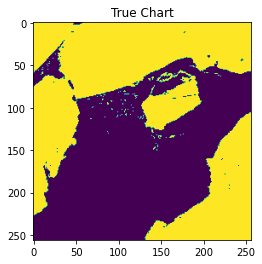

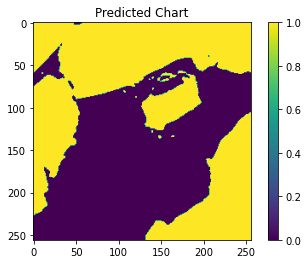

In [350]:
batch = next(iter(val_dataloader))
output = model(batch["sar"])
map = output.argmax(1).squeeze()
plt.imshow(batch["chart"].squeeze())
plt.title("True Chart")
plt.show()
img = plt.imshow(map.numpy()) # convert torch tensor to numpy array before passing into matplotlib
plt.colorbar(img)
plt.title("Predicted Chart")
plt.show()
